In [1]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from pytorch_lightning import Callback, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torch_geometric.nn.conv.gcn_conv import GCNConv

from molNet.dataloader.molecule_loader import PytorchGeomMolGraphFromCsvLoader
from molNet.featurizer.atom_featurizer import default_atom_featurizer
from molNet.nn.models.graph_convolution import MergedPooling, PoolMax, PoolWeightedSum, PoolMin
plt.style.use('seaborn-colorblind')

In [2]:
datafile="../../datasets/delaney-processed.csv"
pd.read_csv(datafile)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


In [3]:
class SimpleGraphConvPredictor(pl.LightningModule):
    def __init__(self,in_feats):
        super().__init__()

        self.save_hyperparameters()
        self.conv1 = GCNConv(in_feats, 64)
        self.conv2 = GCNConv(64, 64)
        self.conv3 = GCNConv(64, 64)
        self.conv4 = GCNConv(64, 64)
        self.conv5 = GCNConv(64, 64)
        self.conv6 = GCNConv(64, 64)
        in_feats = 64
        self.pooling = MergedPooling([
            PoolMax(),
            PoolWeightedSum(in_feats),
            PoolMin()
        ])

        merge_fts=4
        out_feats=1
        add_feats=0
        self.merge = torch.nn.Linear(3*in_feats+add_feats, merge_fts)
        self.predict = torch.nn.Linear(merge_fts, out_feats)

        self.loss = torch.nn.MSELoss()

    def unpacked_forward(self, feats, edges, batch,graph_features):
        feats = self.conv1(feats, edges)
        feats = self.conv2(feats, edges)
        feats = self.conv3(feats, edges)
        feats = self.conv4(feats, edges)
        feats = self.conv5(feats, edges)
        feats = self.conv6(feats, edges)
        feats = self.pooling(feats, batch)
        feats = torch.cat((feats,graph_features.view(feats.shape[0],-1)),dim=1)
        feats = self.merge(feats)
        feats = self.predict(feats)
        return feats

    def forward(self,batch):
        return self.unpacked_forward(feats=batch.x,edges=batch.edge_index,batch=batch.batch,graph_features=batch.graph_features)

    def training_step(self, train_batch, batch_idx):
        logits = self.forward(train_batch)
        loss = self.loss(logits,train_batch.y.reshape(torch.max(train_batch.batch)+1,-1))
        result = pl.TrainResult(minimize=loss)#
        result.log('train_loss', loss, on_epoch=True)
        return result

    def validation_step(self, val_batch, batch_idx):
        logits = self.forward(val_batch)
        loss = self.loss(logits,val_batch.y.reshape(torch.max(val_batch.batch)+1,-1))
        result = pl.EvalResult(checkpoint_on=loss)
        result.log('val_loss', loss)
        return result


    def configure_optimizers(self):
        optimzer = torch.optim.AdamW(self.parameters(), lr=0.00001,amsgrad=True)
        return optimzer

In [4]:
atom_featurizer = default_atom_featurizer

loader = PytorchGeomMolGraphFromCsvLoader(file=datafile,
                                          smiles_column="smiles",
                                          seed=1,
                                          atom_featurizer=atom_featurizer,
                                          y_properties=[
                                              "measured log solubility in mols per litre",
                                        #      "Molecular Weight"
                                          ],
                                          #additional_data=None,
                                          #additional_data=["ESOL predicted log solubility in mols per litre"],
                                          )
model=None
last_checkpoint=None
save_dir=os.getcwd()
file_list= [filename for filename in os.listdir(save_dir) if filename.endswith(".ckpt")]
for filename in sorted(file_list,key=lambda f:int(re.sub('\D', '', f)),reverse=True):
    if filename.endswith(".ckpt"):
        file=os.path.join(save_dir,filename)
        try:
            model = SimpleGraphConvPredictor.load_from_checkpoint(file,
                                                                  map_location=lambda storage, location: storage
                                                                  )
            last_checkpoint = file
            break
        except TypeError as e:
            print(filename,e)
if model is None:
    model=SimpleGraphConvPredictor(len(atom_featurizer))
print(last_checkpoint)
#tb_logger = pl.loggers.TensorBoardLogger('logs/')
#comet_logger = pl.loggers.CometLogger(api_key="HPthUmG6DuNrSwQk7iCC1hKJb",project_name="delany_sol", workspace="juliankimmig")
model

/home/julian/IdeaProjects/molNet/examples/delaney_solubility/epoch=398.ckpt


SimpleGraphConvPredictor(
  (conv1): GCNConv(122, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (conv5): GCNConv(64, 64)
  (conv6): GCNConv(64, 64)
  (pooling): MergedPooling(
    (pooling_layer): ModuleList(
      (0): PoolMax()
      (1): PoolWeightedSum(
        (weighting_of_nodes): Sequential(
          (0): Linear(in_features=64, out_features=1, bias=True)
          (1): Sigmoid()
        )
      )
      (2): PoolMin()
    )
  )
  (merge): Linear(in_features=192, out_features=4, bias=True)
  (predict): Linear(in_features=4, out_features=1, bias=True)
  (loss): MSELoss()
)

In [5]:
checkpoint_callback = ModelCheckpoint(
    filepath=os.getcwd(),
    save_top_k=1,
    verbose=False,
    monitor='val_loss',
    mode='min',
    prefix='sol1_model'
)

class MyPrintingCallback(Callback):

    def on_init_start(self, trainer):
        print('Starting to init trainer!')

    def on_init_end(self, trainer):
        print('trainer is init now')

    def on_train_start(self, trainer, pl_module):
        self._next_paint=trainer.current_epoch*1.1
        os.makedirs(os.path.join(save_dir,"images"),exist_ok=True)
        self.sd = loader.generate_full_dataset()

    def on_train_end(self, trainer, pl_module):
        print('do something when training ends')

    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch>=self._next_paint:
            self._next_paint=trainer.current_epoch*1.1
            tv=[]
            pv=[]
            with torch.no_grad():
                for b in loader.dataloader(self.sd):

                    y=b.y
                    #print(y.numpy().shape)
                    tv.append(y.numpy())
                    y_hat = pl_module(b.to(pl_module.device))
                    pv.extend(y_hat.detach().cpu().numpy())
            tv=np.array(tv)
            pv=np.array(pv)
            for i in range(tv.shape[1]):
                ta,pa = tv[:,i],pv[:,i]
                xmin=ta.min()-(ta.max()-ta.min())*0.1
                xmax=ta.max()+(ta.max()-ta.min())*0.1
                plt.figure(dpi=200)
                plt.plot([xmin,xmax],[xmin,xmax],"--")
                plt.plot(ta,pa, "o")
                plt.xlim(xmin,xmax)
                plt.ylim(xmin,xmax)
                plt.title(trainer.current_epoch)
                plt.savefig(os.path.join(save_dir,"images","{}.png".format(trainer.current_epoch)))
                plt.close()


trainer = pl.Trainer(max_epochs=100000,gpus=1,
                     callbacks=[MyPrintingCallback()],
                     checkpoint_callback=checkpoint_callback,
                         resume_from_checkpoint=last_checkpoint
                         #logger=[tb_logger, comet_logger]
                         )

#    with torch.no_grad():
#        for p in model.predict.parameters():
#            print(p)
trainer.fit(model,loader)

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Checkpoint directory /home/julian/IdeaProjects/molNet/examples/delaney_solubility exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name    | Type          | Params
------------------------------------------
0 | conv1   | GCNConv       | 7 K   
1 | conv2   | GCNConv       | 4 K   
2 | conv3   | GCNConv       | 4 K   
3 | conv4   | GCNConv       | 4 K   
4 | conv5   | GCNConv       | 4 K   


Starting to init trainer!
trainer is init now
do something when training ends



1

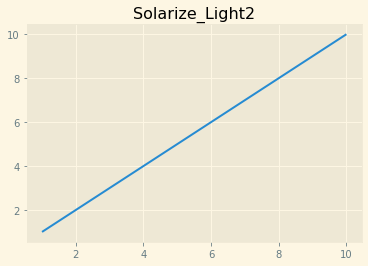

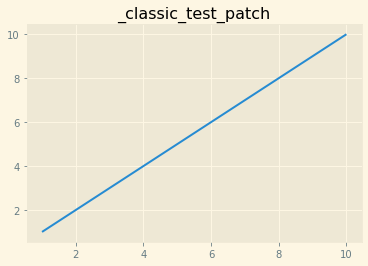

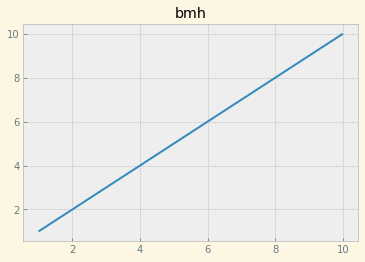

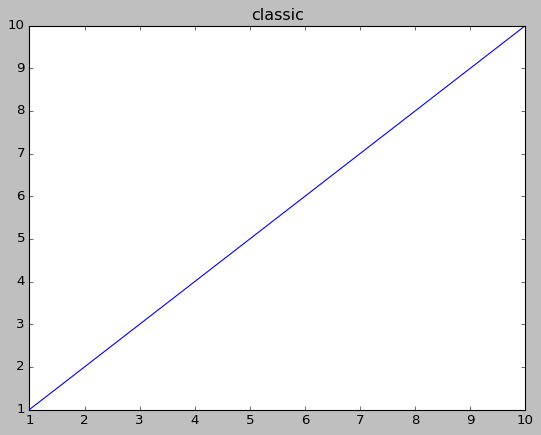

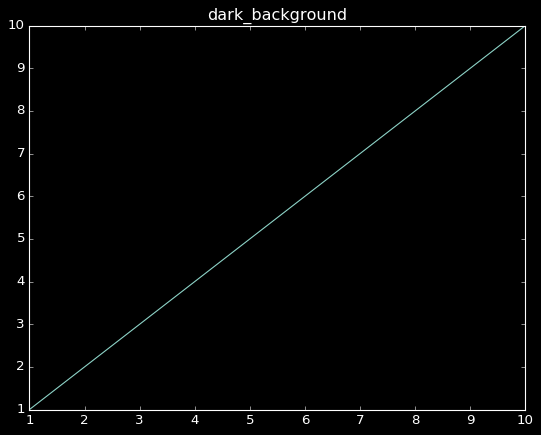

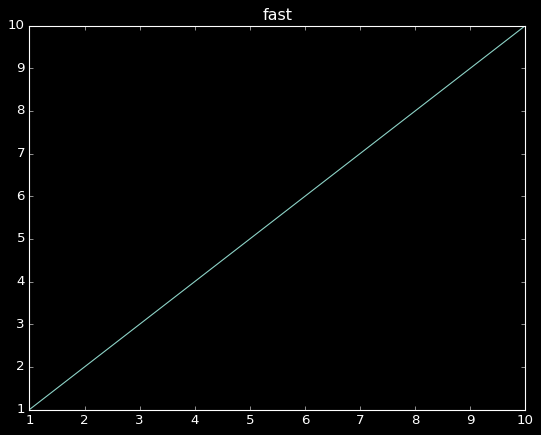

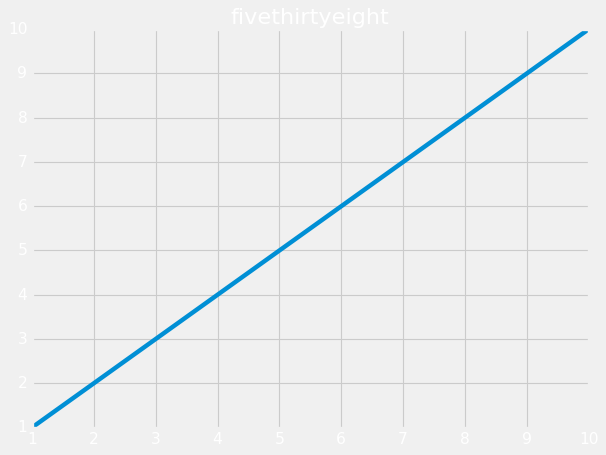

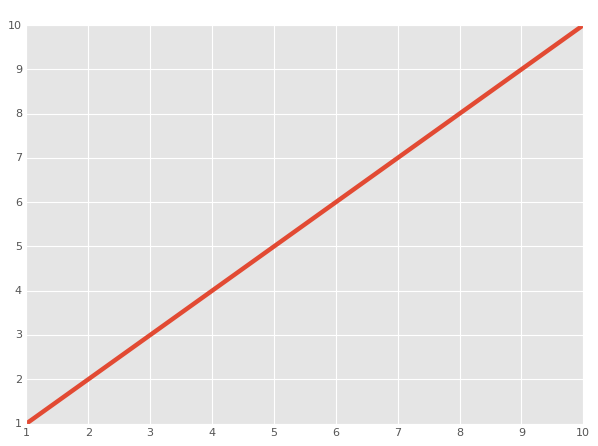

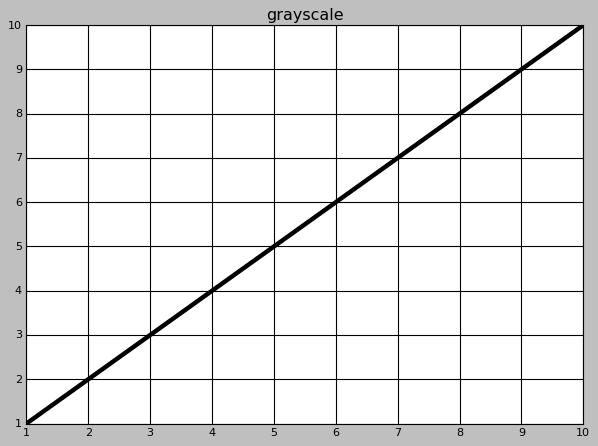

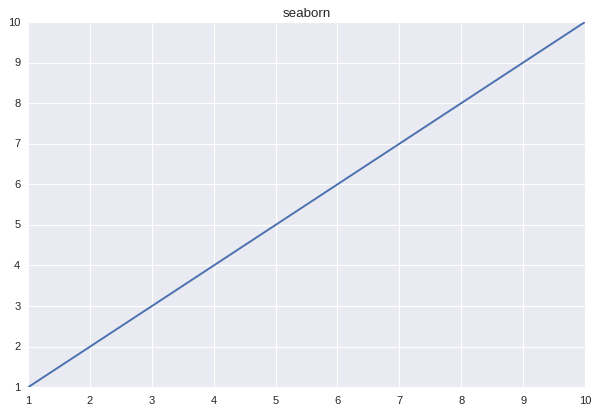

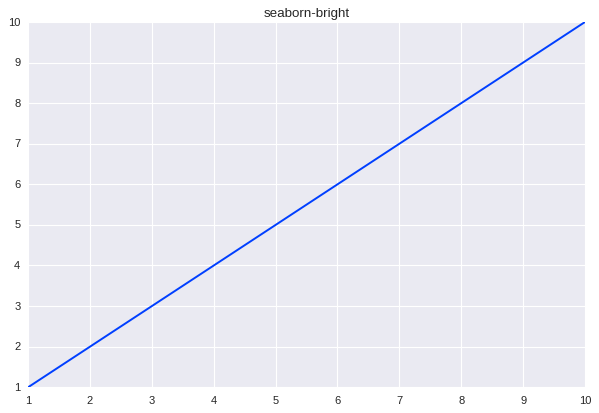

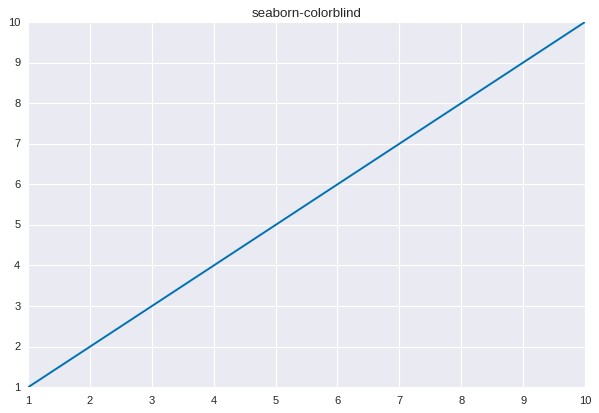

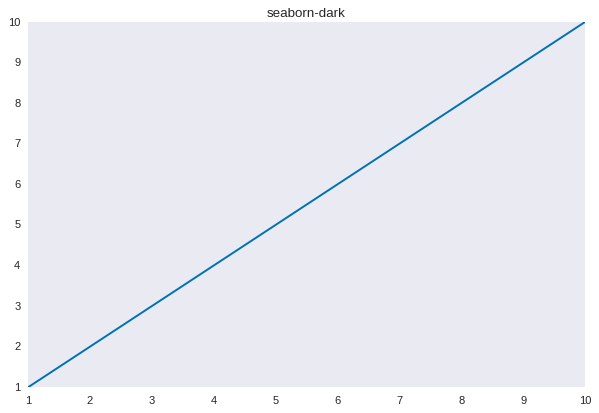

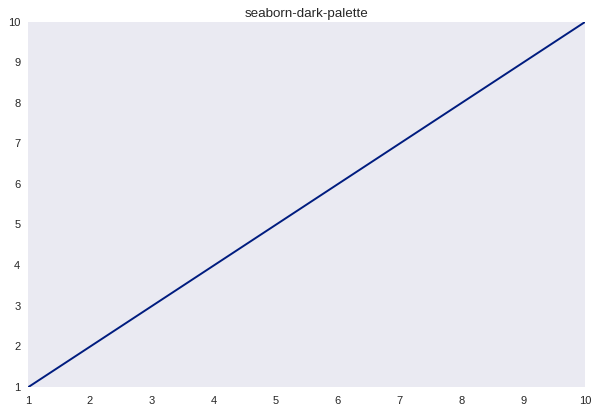

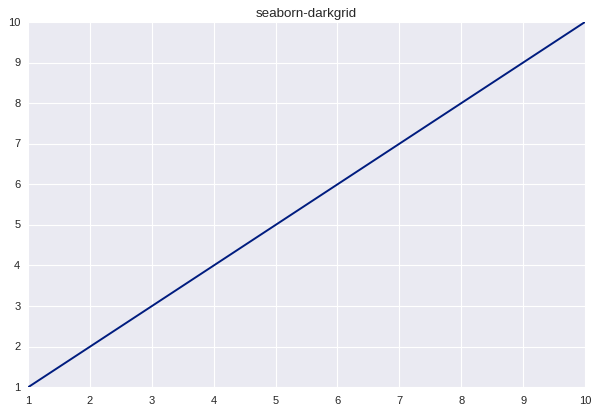

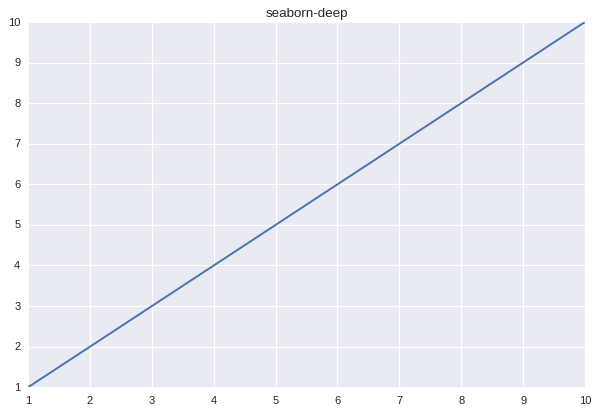

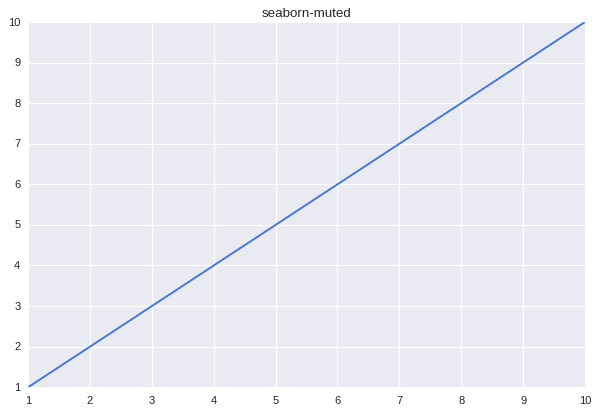

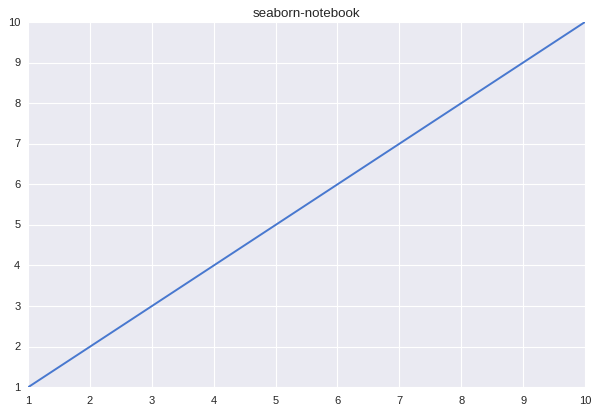

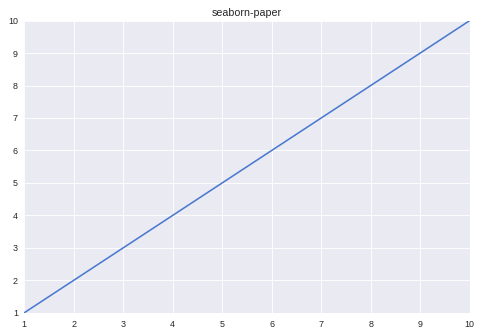

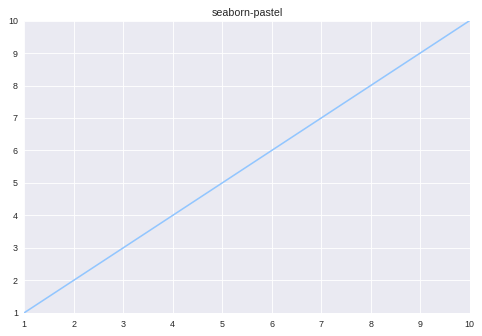

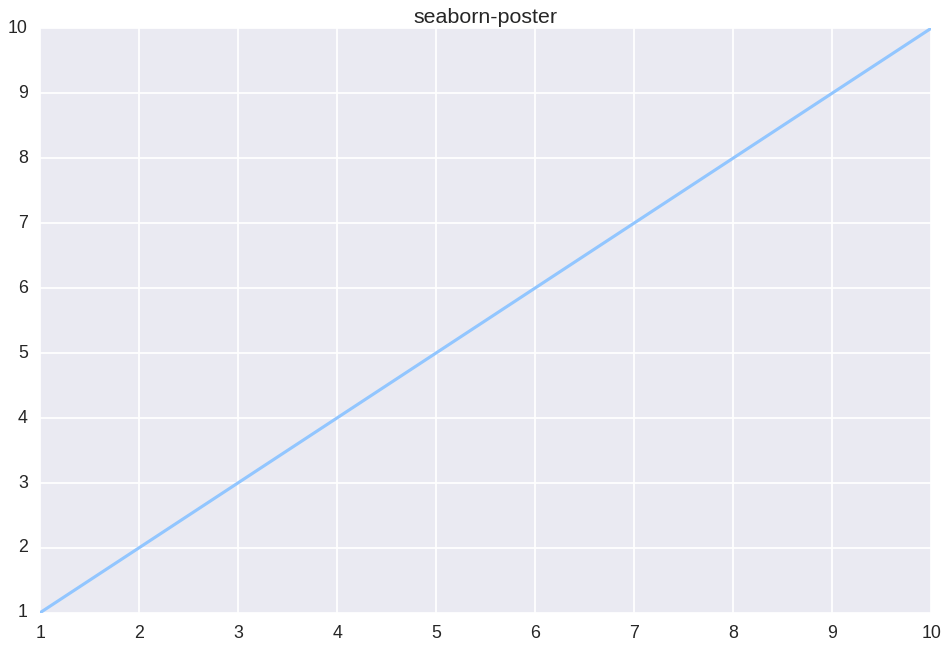

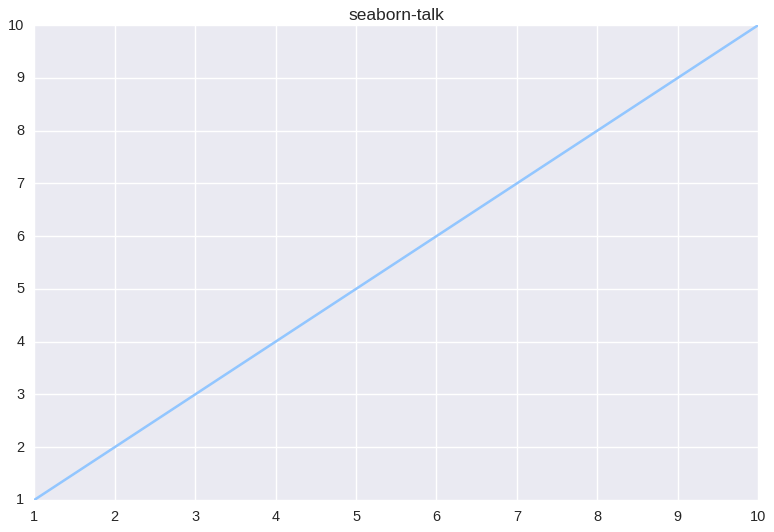

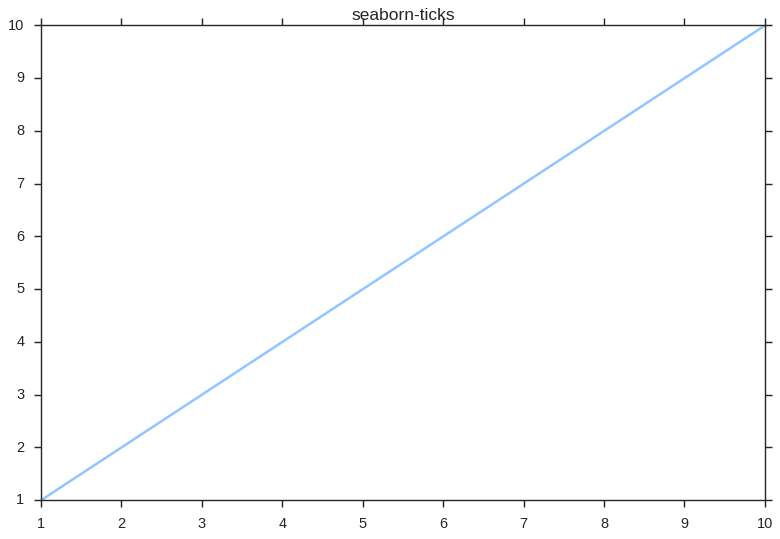

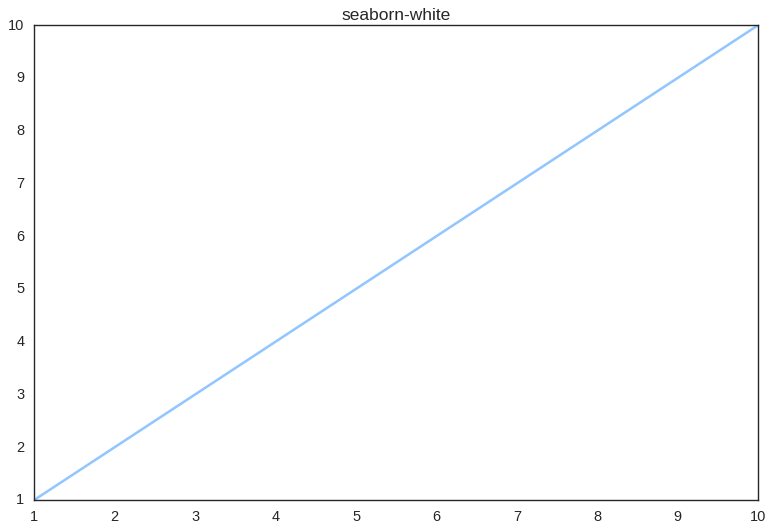

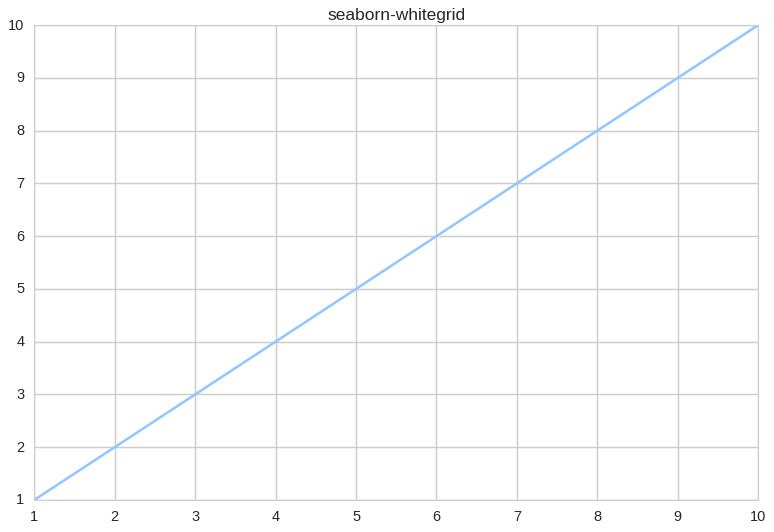

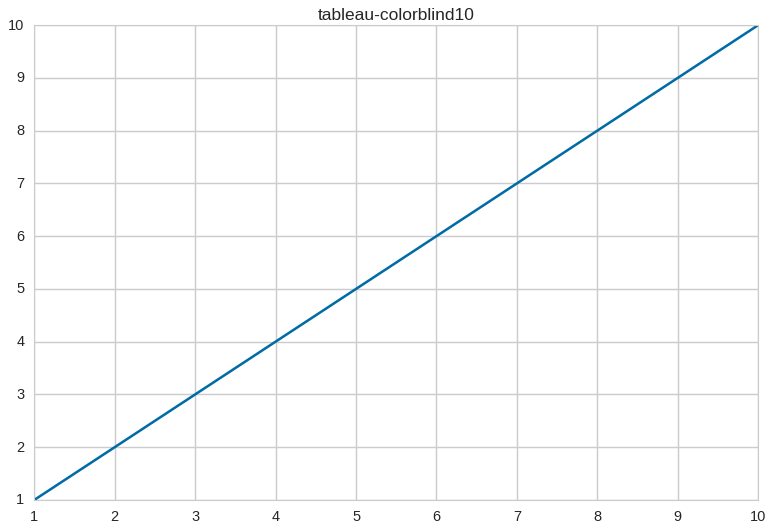

In [6]:
for s in plt.style.available:
    plt.style.use(s)
    plt.plot([1,10],[1,10])
    plt.title(s)
    plt.show()
    plt.close()

In [ ]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']